In [5]:
!pip install transformers torch nltk beautifulsoup4
!pip install vaderSentiment
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import re
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast
import requests
import time
import torch
from bs4 import BeautifulSoup
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from rich.console import Console
from rich.table import Table
from rich import box
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [6]:
# # Define the specific date for filtering
# specific_date = '2023-01-01'

# # Create an empty list to store the filtered records
# filtered_data = []

# print("file_path:", file_path)

# # Read the file in chunks
# chunk_size = 10000  # You can adjust the chunk size based on your system's memory
# for chunk in pd.read_csv(file_path, chunksize=chunk_size, parse_dates=['pub_date'], infer_datetime_format=True):

#     # Filter the chunk for records from or after the specific date
#     chunk_filtered = chunk[chunk['pub_date'] >= specific_date]

#     # Append the filtered chunk data to the list
#     filtered_data.append(chunk_filtered)

#     # If we have 10,000 or more records, break the loop
#     if sum(len(df) for df in filtered_data) >= 10000:
#         break

# # Concatenate the filtered data from all chunks
# filtered_data = pd.concat(filtered_data)

# # Select the first 10,000 records
# selected_records = filtered_data.head(10000)

In [57]:
#drive.mount('/content/drive')
# Loading the dataset
#Please download dataset from the below link
#https://drive.google.com/file/d/1omBK4sbebDNdsyuq3QOSyUmTBqf6pCNr/view?usp=drive_link
file_path = 'selected_records.csv'
df = pd.read_csv(file_path)

In [8]:
df.head()

,abstract,web_url,snippet,lead_paragraph,print_section,print_page,source,multimedia,headline,keywords,...,document_type,news_desk,section_name,byline,type_of_material,_id,word_count,uri,subsection_name,published_date
0,Ms. Peltola notched a major upset against Ms. ...,https://www.nytimes.com/2022/08/31/us/politics...,Ms. Peltola notched a major upset against Ms. ...,In an upset with the potential to reverberate ...,A,12.0,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","{'main': 'Mary Peltola, a Democrat, Defeats Sa...","[{'name': 'glocations', 'value': 'ALASKA', 'ra...",...,article,Politics,U.S.,"{'original': 'By Blake Hounshell', 'person': [...",News,nyt://article/ee36e5da-abd1-5596-a53e-e33f0648...,1163.0,nyt://article/ee36e5da-abd1-5596-a53e-e33f0648...,Politics,2022-09-01 00:15:51+00:00
1,Mr. Gorbachev was charming and presented himse...,https://www.nytimes.com/2022/08/31/us/politics...,Mr. Gorbachev was charming and presented himse...,WASHINGTON — For his first four years in offic...,A,7.0,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'How Reagan and Bush Overcame Skeptic...,"[{'name': 'subject', 'value': 'Cold War Era', ...",...,article,Washington,U.S.,"{'original': 'By Peter Baker', 'person': [{'fi...",News,nyt://article/182086d4-18cb-5905-af6f-541bf13c...,1354.0,nyt://article/182086d4-18cb-5905-af6f-541bf13c...,Politics,2022-09-01 00:23:50+00:00
2,If two nights earlier was about posterity and ...,https://www.nytimes.com/2022/08/31/sports/tenn...,If two nights earlier was about posterity and ...,The U.S. Open threw the closest thing to a far...,B,8.0,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Serena Williams’s Magical Run at the...,"[{'name': 'subject', 'value': 'Tennis', 'rank'...",...,article,Sports,Sports,"{'original': 'By Matthew Futterman', 'person':...",News,nyt://article/528ee250-f930-5c1f-877c-1e2dcb3f...,1200.0,nyt://article/528ee250-f930-5c1f-877c-1e2dcb3f...,Tennis,2022-09-01 01:45:29+00:00
3,A filing claimed that the Justice Department w...,https://www.nytimes.com/2022/08/31/us/politics...,A filing claimed that the Justice Department w...,WASHINGTON — Former President Donald J. Trump’...,A,17.0,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Trump’s Lawyers Renew Push for Speci...,"[{'name': 'subject', 'value': 'Classified Info...",...,article,Washington,U.S.,"{'original': 'By Charlie Savage, Alan Feuer an...",News,nyt://article/810358ae-0037-5f2f-87bf-fcd0e16f...,954.0,nyt://article/810358ae-0037-5f2f-87bf-fcd0e16f...,Politics,2022-09-01 02:15:14+00:00
4,Kontaveit was up for the challenge of facing W...,https://www.nytimes.com/2022/08/31/sports/tenn...,Kontaveit was up for the challenge of facing W...,Anett Kontaveit walked out of the players’ tun...,B,9.0,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'It Was Anett Kontaveit Against Seren...,"[{'name': 'persons', 'value': 'Williams, Seren...",...,article,Sports,Sports,"{'original': 'By David Waldstein', 'person': [...",News,nyt://article/90469ddf-9b85-5ddf-9345-94183f58...,967.0,nyt://article/90469ddf-9b85-5ddf-9345-94183f58...,Tennis,2022-09-01 02:17:26+00:00


In [9]:
df.shape[0]

9757

In [10]:
df['published_date'] = pd.to_datetime(df['pub_date'])
df.dtypes

,0
abstract,object
web_url,object
snippet,object
lead_paragraph,object
print_section,object
print_page,float64
source,object
multimedia,object
headline,object
keywords,object


In [11]:
start_date = df['pub_date'].min()
end_date = df['pub_date'].max()

# Displaying the results
print("Start Date:", start_date)
print("End Date:", end_date)

Start Date: 2022-09-01 00:15:51+00:00
End Date: 2024-09-01 07:00:23+00:00


In [12]:
import pandas as pd
import ast
import re


# file_path = '/content/drive/My Drive/606/selected_records.csv'
# df = pd.read_csv(file_path)

# Function to extract 'main' from the dictionary in the 'headline' column
def extract_main(headline):
    try:

        headline_dict = ast.literal_eval(headline)
        return headline_dict.get('main', '')
    except (ValueError, SyntaxError):
        return ''

# Function to clean text by removing unwanted characters
def clean_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

df['main_headline'] = df['headline'].apply(extract_main)
df['main_headline_clean'] = df['main_headline'].apply(clean_text)

# Saving the updated DataFrame to a new CSV file
output_file_path = 'cleaned_main_headlines.csv'
df.to_csv(output_file_path, index=False)

print(df[['main_headline_clean']].head())


                                 main_headline_clean
0  Mary Peltola a Democrat Defeats Sarah Palin in...
1  How Reagan and Bush Overcame Skepticism to Col...
2  Serena Williamss Magical Run at the US Open Is...
3  Trumps Lawyers Renew Push for Special Master i...
4  It Was Anett Kontaveit Against Serena Williams...


In [13]:
def extract_name_value(keywords):
    try:
        keywords_list = ast.literal_eval(keywords)
        return "; ".join([f"{item['name']}:{item['value']}" for item in keywords_list])
    except (ValueError, SyntaxError):
        return ""

# Applying the function to the keywords column
df['extracted_keywords'] = df['keywords'].apply(extract_name_value)

In [14]:
selected_records = df
selected_records.head()

,abstract,web_url,snippet,lead_paragraph,print_section,print_page,source,multimedia,headline,keywords,...,byline,type_of_material,_id,word_count,uri,subsection_name,published_date,main_headline,main_headline_clean,extracted_keywords
0,Ms. Peltola notched a major upset against Ms. ...,https://www.nytimes.com/2022/08/31/us/politics...,Ms. Peltola notched a major upset against Ms. ...,In an upset with the potential to reverberate ...,A,12.0,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","{'main': 'Mary Peltola, a Democrat, Defeats Sa...","[{'name': 'glocations', 'value': 'ALASKA', 'ra...",...,"{'original': 'By Blake Hounshell', 'person': [...",News,nyt://article/ee36e5da-abd1-5596-a53e-e33f0648...,1163.0,nyt://article/ee36e5da-abd1-5596-a53e-e33f0648...,Politics,2022-09-01 00:15:51+00:00,"Mary Peltola, a Democrat, Defeats Sarah Palin ...",Mary Peltola a Democrat Defeats Sarah Palin in...,"glocations:ALASKA; subject:Elections, House of..."
1,Mr. Gorbachev was charming and presented himse...,https://www.nytimes.com/2022/08/31/us/politics...,Mr. Gorbachev was charming and presented himse...,WASHINGTON — For his first four years in offic...,A,7.0,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'How Reagan and Bush Overcame Skeptic...,"[{'name': 'subject', 'value': 'Cold War Era', ...",...,"{'original': 'By Peter Baker', 'person': [{'fi...",News,nyt://article/182086d4-18cb-5905-af6f-541bf13c...,1354.0,nyt://article/182086d4-18cb-5905-af6f-541bf13c...,Politics,2022-09-01 00:23:50+00:00,How Reagan and Bush Overcame Skepticism to Col...,How Reagan and Bush Overcame Skepticism to Col...,subject:Cold War Era; subject:Arms Control and...
2,If two nights earlier was about posterity and ...,https://www.nytimes.com/2022/08/31/sports/tenn...,If two nights earlier was about posterity and ...,The U.S. Open threw the closest thing to a far...,B,8.0,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Serena Williams’s Magical Run at the...,"[{'name': 'subject', 'value': 'Tennis', 'rank'...",...,"{'original': 'By Matthew Futterman', 'person':...",News,nyt://article/528ee250-f930-5c1f-877c-1e2dcb3f...,1200.0,nyt://article/528ee250-f930-5c1f-877c-1e2dcb3f...,Tennis,2022-09-01 01:45:29+00:00,Serena Williams’s Magical Run at the U.S. Open...,Serena Williamss Magical Run at the US Open Is...,subject:Tennis; subject:United States Open (Te...
3,A filing claimed that the Justice Department w...,https://www.nytimes.com/2022/08/31/us/politics...,A filing claimed that the Justice Department w...,WASHINGTON — Former President Donald J. Trump’...,A,17.0,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Trump’s Lawyers Renew Push for Speci...,"[{'name': 'subject', 'value': 'Classified Info...",...,"{'original': 'By Charlie Savage, Alan Feuer an...",News,nyt://article/810358ae-0037-5f2f-87bf-fcd0e16f...,954.0,nyt://article/810358ae-0037-5f2f-87bf-fcd0e16f...,Politics,2022-09-01 02:15:14+00:00,Trump’s Lawyers Renew Push for Special Master ...,Trumps Lawyers Renew Push for Special Master i...,subject:Classified Information and State Secre...
4,Kontaveit was up for the challenge of facing W...,https://www.nytimes.com/2022/08/31/sports/tenn...,Kontaveit was up for the challenge of facing W...,Anett Kontaveit walked out of the players’ tun...,B,9.0,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'It Was Anett Kontaveit Against Seren...,"[{'name': 'persons', 'value': 'Williams, Seren...",...,"{'original': 'By David Waldstein', 'person': [...",News,nyt://article/90469ddf-9b85-5ddf-9345-94183f58...,967.0,nyt://article/90469ddf-9b85-5ddf-9345-94183f58...,Tennis,2022-09-01 02:17:26+00:00,It Was Anett Kontaveit Against Serena Williams...,It Was Anett Kontaveit Against Serena Williams...,"persons:Williams, Serena; persons:Kontaveit, A..."


In [15]:
selected_records.columns

Index(['abstract', 'web_url', 'snippet', 'lead_paragraph', 'print_section',
       'print_page', 'source', 'multimedia', 'headline', 'keywords',
       'pub_date', 'document_type', 'news_desk', 'section_name', 'byline',
       'type_of_material', '_id', 'word_count', 'uri', 'subsection_name',
       'published_date', 'main_headline', 'main_headline_clean',
       'extracted_keywords'],
      dtype='object')

In [16]:
from collections import Counter
keywords = selected_records['extracted_keywords'].dropna().str.split(',').sum()
keyword_counts = Counter(keywords)
print(keyword_counts.most_common(10))

[('persons:Trump', 121), ('persons:Biden', 115), (' Donald J', 110), (' Joseph R Jr', 88), (' Joseph R Jr; persons:Trump', 60), (' Vladimir V; persons:Zelensky', 54), ('subject:Books and Literature', 39), ('subject:Storming of the US Capitol (Jan', 39), ('subject:Television; subject:Movies', 37), (' NY)', 36)]


In [17]:
selected_records['word_count'].mean()

1146.749410679512

In [18]:
selected_records[['main_headline_clean', 'word_count']].sort_values(by='word_count', ascending=False).head(10)

,main_headline_clean,word_count
2867,Was This Billion Deal the Worst Merger Ever,9292.0
288,Pop and Jazz Albums Shows and Festivals Coming...,8299.0
4196,Benedict XVI First Modern Pope to Resign Dies at,7116.0
302,Queen Elizabeth II Dies at Was Britains Longes...,6824.0
1112,They Legitimized the Myth of a Stolen Election...,5808.0
4535,Hunter Bidens Tangled Tale Comes Front and Center,5279.0
239,The NFL Season Is Ready to Launch,5242.0
8262,What to See in NYC Galleries in May,5190.0
1747,Ken Burns Wishes More People Would Call Willa ...,4624.0
8902,Born This Way Born Which Way,4612.0


<Axes: title={'center': 'Top 5 News Desks'}, xlabel='news_desk'>

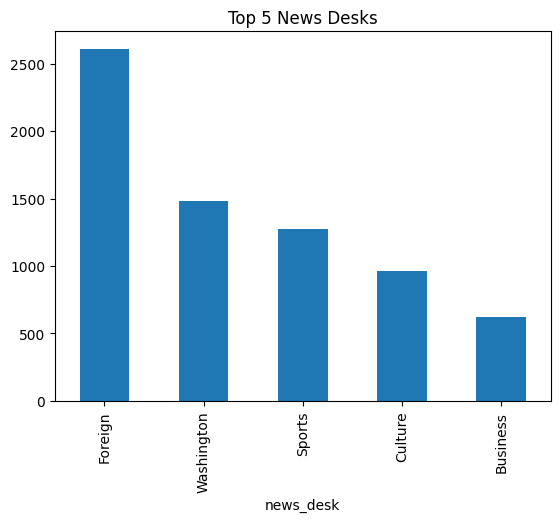

In [19]:
#Top 5 news desks with most articles
selected_records['news_desk'].value_counts().head(5).plot(kind='bar', title="Top 5 News Desks")


<Axes: title={'center': 'Articles by sections'}, xlabel='section_name'>

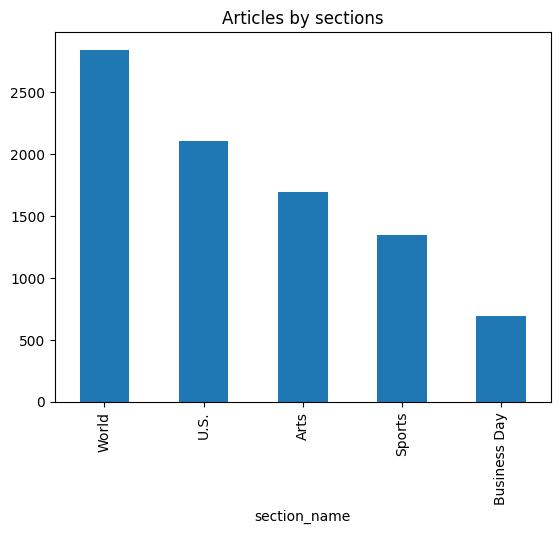

In [20]:
#Distribution of articles by source
selected_records['section_name'].value_counts().head(5).plot(kind='bar', title="Articles by sections")

<Axes: title={'center': 'Top 5 Subsections'}, xlabel='subsection_name'>

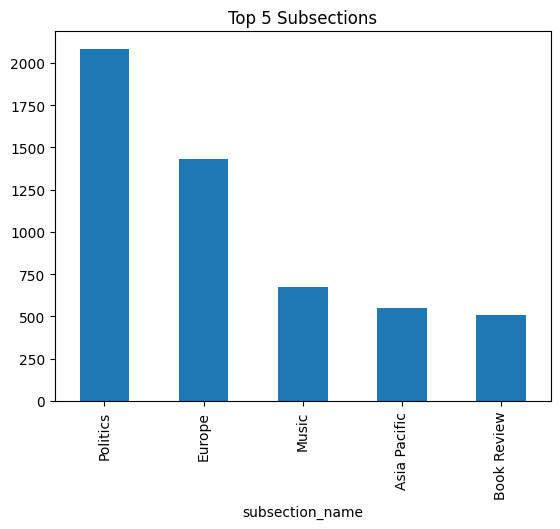

In [21]:
#Subsection analysis
selected_records['subsection_name'].value_counts().head(5).plot(kind='bar', title="Top 5 Subsections")

In [22]:
#Top 10 authors with the most articles
#selected_records['byline'].value_counts().head(10).plot(kind='bar', title="Top 10 Authors")

In [23]:
# Function to extract the 'original' field from the byline entry
def extract_original(byline):
    if isinstance(byline, dict):
        original = byline.get('original', 'Unknown')
        return original if original else 'Unknown'
    elif isinstance(byline, str):
        try:
            byline_dict = ast.literal_eval(byline)
            if isinstance(byline_dict, dict):
                original = byline_dict.get('original', 'Unknown')
                return original if original else 'Unknown'
            else:
                return 'Unknown'
        except (ValueError, SyntaxError):
            return 'Unknown'
    else:
        return 'Unknown'


# Applying the function to create a new column
selected_records['author_name'] = selected_records['byline'].apply(extract_original)

In [24]:
selected_records.head()

,abstract,web_url,snippet,lead_paragraph,print_section,print_page,source,multimedia,headline,keywords,...,type_of_material,_id,word_count,uri,subsection_name,published_date,main_headline,main_headline_clean,extracted_keywords,author_name
0,Ms. Peltola notched a major upset against Ms. ...,https://www.nytimes.com/2022/08/31/us/politics...,Ms. Peltola notched a major upset against Ms. ...,In an upset with the potential to reverberate ...,A,12.0,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...","{'main': 'Mary Peltola, a Democrat, Defeats Sa...","[{'name': 'glocations', 'value': 'ALASKA', 'ra...",...,News,nyt://article/ee36e5da-abd1-5596-a53e-e33f0648...,1163.0,nyt://article/ee36e5da-abd1-5596-a53e-e33f0648...,Politics,2022-09-01 00:15:51+00:00,"Mary Peltola, a Democrat, Defeats Sarah Palin ...",Mary Peltola a Democrat Defeats Sarah Palin in...,"glocations:ALASKA; subject:Elections, House of...",By Blake Hounshell
1,Mr. Gorbachev was charming and presented himse...,https://www.nytimes.com/2022/08/31/us/politics...,Mr. Gorbachev was charming and presented himse...,WASHINGTON — For his first four years in offic...,A,7.0,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'How Reagan and Bush Overcame Skeptic...,"[{'name': 'subject', 'value': 'Cold War Era', ...",...,News,nyt://article/182086d4-18cb-5905-af6f-541bf13c...,1354.0,nyt://article/182086d4-18cb-5905-af6f-541bf13c...,Politics,2022-09-01 00:23:50+00:00,How Reagan and Bush Overcame Skepticism to Col...,How Reagan and Bush Overcame Skepticism to Col...,subject:Cold War Era; subject:Arms Control and...,By Peter Baker
2,If two nights earlier was about posterity and ...,https://www.nytimes.com/2022/08/31/sports/tenn...,If two nights earlier was about posterity and ...,The U.S. Open threw the closest thing to a far...,B,8.0,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Serena Williams’s Magical Run at the...,"[{'name': 'subject', 'value': 'Tennis', 'rank'...",...,News,nyt://article/528ee250-f930-5c1f-877c-1e2dcb3f...,1200.0,nyt://article/528ee250-f930-5c1f-877c-1e2dcb3f...,Tennis,2022-09-01 01:45:29+00:00,Serena Williams’s Magical Run at the U.S. Open...,Serena Williamss Magical Run at the US Open Is...,subject:Tennis; subject:United States Open (Te...,By Matthew Futterman
3,A filing claimed that the Justice Department w...,https://www.nytimes.com/2022/08/31/us/politics...,A filing claimed that the Justice Department w...,WASHINGTON — Former President Donald J. Trump’...,A,17.0,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'Trump’s Lawyers Renew Push for Speci...,"[{'name': 'subject', 'value': 'Classified Info...",...,News,nyt://article/810358ae-0037-5f2f-87bf-fcd0e16f...,954.0,nyt://article/810358ae-0037-5f2f-87bf-fcd0e16f...,Politics,2022-09-01 02:15:14+00:00,Trump’s Lawyers Renew Push for Special Master ...,Trumps Lawyers Renew Push for Special Master i...,subject:Classified Information and State Secre...,"By Charlie Savage, Alan Feuer and Maggie Haberman"
4,Kontaveit was up for the challenge of facing W...,https://www.nytimes.com/2022/08/31/sports/tenn...,Kontaveit was up for the challenge of facing W...,Anett Kontaveit walked out of the players’ tun...,B,9.0,The New York Times,"[{'rank': 0, 'subtype': 'xlarge', 'caption': N...",{'main': 'It Was Anett Kontaveit Against Seren...,"[{'name': 'persons', 'value': 'Williams, Seren...",...,News,nyt://article/90469ddf-9b85-5ddf-9345-94183f58...,967.0,nyt://article/90469ddf-9b85-5ddf-9345-94183f58...,Tennis,2022-09-01 02:17:26+00:00,It Was Anett Kontaveit Against Serena Williams...,It Was Anett Kontaveit Against Serena Williams...,"persons:Williams, Serena; persons:Kontaveit, A...",By David Waldstein


In [25]:
top_authors = selected_records['author_name'].value_counts().head(10)

# Displaying the top 10 author names
print("Top 10 Authors:")
print(top_authors)

Top 10 Authors:
author_name
Unknown                358
By Rory Smith           92
By Mark Landler         75
By Tyler Kepner         73
By Jeanna Smialek       62
By Peter Baker          58
By Luke Broadwater      57
By Zachary Woolfe       57
By James Wagner         56
By Jonathan Weisman     55
Name: count, dtype: int64


In [26]:
selected_records['author_name'].unique()

array(['By Blake Hounshell', 'By Peter Baker', 'By Matthew Futterman',
       ..., 'By Geordon Wollner',
       'By Frances Robles and Marian Carrasquero', 'By Aimee Ortiz'],
      dtype=object)

<Axes: title={'center': 'Top 10 Authors'}, xlabel='author_name'>

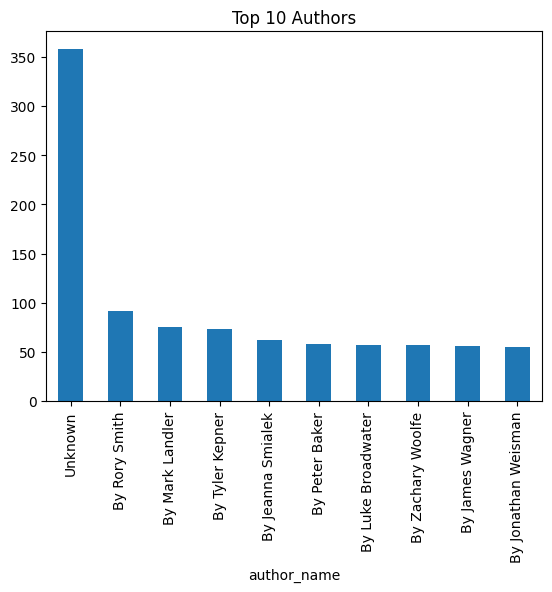

In [27]:
#Subsection analysis
selected_records['author_name'].value_counts().head(10).plot(kind='bar', title="Top 10 Authors")

###Rule to Define Sentiment

In [28]:
def assign_sentiment_label(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

## TOKENISATION BY VADER

In [29]:
nltk.download('vader_lexicon')
nltk.download('stopwords')

# drive.mount('/content/drive')
# file_path = '/content/drive/My Drive/606/selected_records.csv'
# df = pd.read_csv(file_path)
#file_path = 'D:/Browser_Downloads/selected_records.csv'
#df = pd.read_csv(file_path)

# Initializing VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Defining a text preprocessing function
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

# Initialization of lists to store results for each row
positive_scores = []
negative_scores = []
neutral_scores = []
compound_scores = []

# Iterating over each row to process text and apply sentiment analysis
for index, row in df.iterrows():
    # Preprocess the text
    cleaned_text = preprocess_text(row['abstract'])

    # sentiment scores
    sentiment = sid.polarity_scores(cleaned_text)

    # Appending each sentiment score to its respective list
    positive_scores.append(sentiment['pos'])
    negative_scores.append(sentiment['neg'])
    neutral_scores.append(sentiment['neu'])
    compound_scores.append(sentiment['compound'])

    # Printing the progress every 1000 rows
    if (index + 1) % 1000 == 0:
        print(f"Processed {index + 1} rows")

# Adding sentiment scores as new columns in the DataFrame
df['vader_positive_score'] = positive_scores
df['vader_negative_score'] = negative_scores
df['vader_neutral_score'] = neutral_scores
df['vader_compound_score'] = compound_scores
df['vader_sentiment'] =df['vader_compound_score'].apply(assign_sentiment_label)

df_styled = df[['abstract', 'web_url', 'snippet', 'subsection_name', 'vader_positive_score',
                'vader_negative_score', 'vader_neutral_score', 'vader_compound_score']].head()

# Display
styled_df = df_styled.style.format({
    'positive_score': '{:.3f}',
    'negative_score': '{:.3f}',
    'neutral_score': '{:.3f}',
    'compound_score': '{:.4f}'
}).hide(axis='index').set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-size', '14px')]},
    {'selector': 'td', 'props': [('text-align', 'left'), ('font-size', '12px')]},
    {'selector': 'table', 'props': [('width', '100%'), ('border-collapse', 'collapse')]},
])


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Processed 1000 rows
Processed 2000 rows
Processed 3000 rows
Processed 4000 rows
Processed 5000 rows
Processed 6000 rows
Processed 7000 rows
Processed 8000 rows
Processed 9000 rows


In [30]:
df['vader_sentiment'].value_counts()

,count
vader_sentiment,
Positive,3782
Negative,3649
Neutral,2326


In [31]:
styled_df

abstract,web_url,snippet,subsection_name,vader_positive_score,vader_negative_score,vader_neutral_score,vader_compound_score
"Ms. Peltola notched a major upset against Ms. Palin and will finish the remaining four months of the term of Representative Don Young, who died in March.",https://www.nytimes.com/2022/08/31/us/politics/mary-peltola-alaska-special-election.html,"Ms. Peltola notched a major upset against Ms. Palin and will finish the remaining four months of the term of Representative Don Young, who died in March.",Politics,0.000000,0.317000,0.683000,-0.757400
"Mr. Gorbachev was charming and presented himself as a modernizer, but neither Ronald Reagan nor George Bush was convinced he was for real. They would both be proved wrong.",https://www.nytimes.com/2022/08/31/us/politics/reagan-bush-gorbachev.html,"Mr. Gorbachev was charming and presented himself as a modernizer, but neither Ronald Reagan nor George Bush was convinced he was for real. They would both be proved wrong.",Politics,0.301000,0.144000,0.556000,0.526700
"If two nights earlier was about posterity and sweet send-offs, Round 2 was about doing everything possible to win a tennis match, as Williams beat the world No. 2, Anett Kontaveit, in three sets.",https://www.nytimes.com/2022/08/31/sports/tennis/serena-williams-us-open-win.html,"If two nights earlier was about posterity and sweet send-offs, Round 2 was about doing everything possible to win a tennis match, as Williams beat the world No. 2, Anett Kontaveit, in three sets.",Tennis,0.264000,0.000000,0.736000,0.778300
"A filing claimed that the Justice Department was criminalizing the former president’s possession of “his own presidential records,” a stance at odds with the Presidential Records Act.",https://www.nytimes.com/2022/08/31/us/politics/trump-court-documents.html,"A filing claimed that the Justice Department was criminalizing the former president’s possession of “his own presidential records,” a stance at odds with the Presidential Records Act.",Politics,0.195000,0.000000,0.805000,0.526700
"Kontaveit was up for the challenge of facing Williams in front of fans who had little interest in her winning as they celebrate Williams’s career. She forced a third set, but the fans got what they wanted.",https://www.nytimes.com/2022/08/31/sports/tennis/serena-williams-kontaveit-crowd-us-open.html,"Kontaveit was up for the challenge of facing Williams in front of fans who had little interest in her winning as they celebrate Williams’s career. She forced a third set, but the fans got what they wanted.",Tennis,0.398000,0.113000,0.489000,0.762500


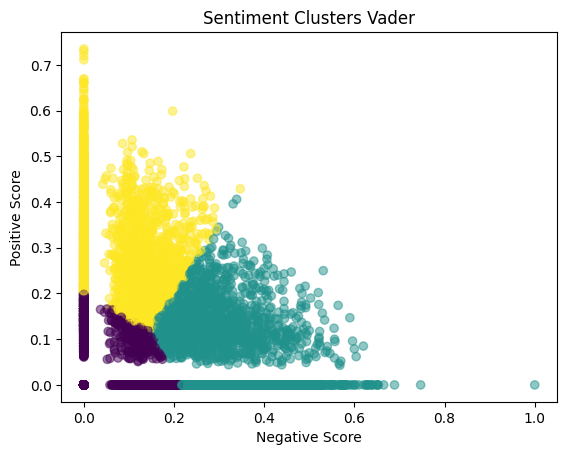

In [32]:
features = df[['vader_negative_score', 'vader_neutral_score', 'vader_positive_score']].values

# Applying K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Visualization of clusters
plt.scatter(features[:, 0], features[:, 2], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Negative Score')
plt.ylabel('Positive Score')
plt.title('Sentiment Clusters Vader')
plt.show()

## TOKENISATION BY BERT

In [33]:
# Loading pretrained BERT model and tokenizer
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

class SentimentDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=256):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
        }

# Preprocessing text column
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    return text.strip()

df['abstract'] = df['abstract'].apply(preprocess_text)

# Preparing dataset and dataloader
batch_size = 64
dataset = SentimentDataset(df['abstract'].tolist(), tokenizer)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Lists to store scores
negative_scores = []
neutral_scores = []
positive_scores = []

# Predicting sentiment
model.eval()
with torch.no_grad():
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # Predicting sentiment
        outputs = model(input_ids, attention_mask=attention_mask)
        probabilities = F.softmax(outputs.logits, dim=1).cpu().numpy()

        # Extracting scores
        for prob in probabilities:
            # Aggregate of scores
            negative_scores.append(prob[0] + prob[1])
            neutral_scores.append(prob[2])
            positive_scores.append(prob[3] + prob[4])

df['bert_negative_score'] = negative_scores
df['bert_neutral_score'] = neutral_scores
df['bert_positive_score'] = positive_scores
df['bert_compound_score'] = (df['bert_positive_score'] - df['bert_negative_score']) * (1 - df['bert_neutral_score'])
df['bert_sentiment'] =df['bert_compound_score'].apply(assign_sentiment_label)

# Saving the updated DataFrame to a CSV file
output_file = 'dataset_with_sentiment_scores.csv'
df.to_csv(output_file, index=False)
print(f"Sentiment scores saved to {output_file}")

# Display
print(df[['abstract', 'bert_negative_score', 'bert_neutral_score', 'bert_positive_score']].head())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

Sentiment scores saved to dataset_with_sentiment_scores.csv
                                            abstract  bert_negative_score  \
0  Ms. Peltola notched a major upset against Ms. ...             0.412397   
1  Mr. Gorbachev was charming and presented himse...             0.702148   
2  If two nights earlier was about posterity and ...             0.385246   
3  A filing claimed that the Justice Department w...             0.738849   
4  Kontaveit was up for the challenge of facing W...             0.164919   

   bert_neutral_score  bert_positive_score  
0            0.255590             0.332014  
1            0.237888             0.059964  
2            0.263683             0.351071  
3            0.161241             0.099910  
4            0.378442             0.456639  


In [34]:
df['bert_sentiment'].value_counts()

,count
bert_sentiment,
Positive,4562
Negative,3797
Neutral,1398


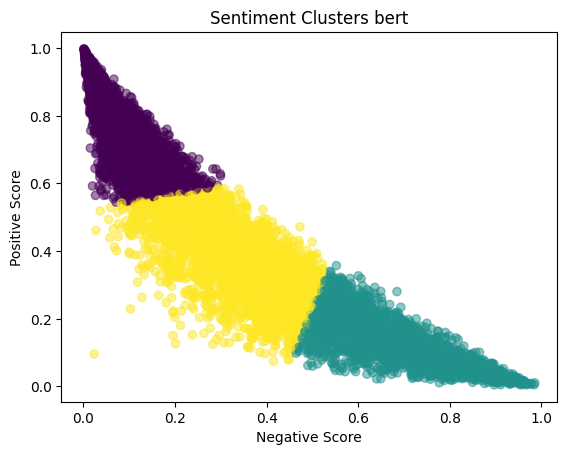

In [35]:
features = df[['bert_negative_score', 'bert_neutral_score', 'bert_positive_score']].values

# Applying K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Visualization of clusters
plt.scatter(features[:, 0], features[:, 2], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Negative Score')
plt.ylabel('Positive Score')
plt.title('Sentiment Clusters bert')
plt.show()

##TOKENISATION by RoBERTa

In [36]:
# Loading the RoBERTa model and tokenizer
model_name = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Preprocess function for the text
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text


class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.texts = df['abstract'].apply(preprocess_text).tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_len, return_tensors="pt")
        return encoding

# Creating a DataLoader for batch processing
batch_size = 150
dataset = SentimentDataset(df, tokenizer)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Lists to store results
positive_scores = []
neutral_scores = []
negative_scores = []
compound_scores = []

# Function to get sentiment scores from RoBERTa for batch processing
def get_roberta_sentiment_batch(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    scores = outputs.logits.softmax(dim=-1).cpu().numpy()
    return scores

# Iterations over the DataLoader to process batches
for batch in dataloader:
    input_ids = batch['input_ids'].squeeze(1).to(device)
    attention_mask = batch['attention_mask'].squeeze(1).to(device)

    with autocast():
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)

    scores_batch = outputs.logits.softmax(dim=-1).cpu().numpy()

    # Appending the scores to respective lists
    for scores in scores_batch:
        negative_scores.append(scores[0])
        neutral_scores.append(scores[1])
        positive_scores.append(scores[2])


        compound_scores.append((scores[2] - scores[0])*(1-scores[1]))


    if len(negative_scores) % 1000 == 0:
        print(f"Processed {len(negative_scores)} rows")

# Adding sentiment scores to the DataFrame
df['roberta_positive_score'] = positive_scores
df['roberta_neutral_score'] = neutral_scores
df['roberta_negative_score'] = negative_scores
df['roberta_compound_score'] = compound_scores
df['roberta_sentiment'] =df['roberta_compound_score'].apply(assign_sentiment_label)

output_file_path = 'updated_records_with_sentiment.csv'
df.to_csv(output_file_path, index=False)
print(f"Updated DataFrame saved to {output_file_path}")



# Loading the updated DataFrame from the saved file
df_updated = pd.read_csv(output_file_path)

# Display
print(df_updated.head(10).to_markdown(index=False))

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-36-616a23a8c999>:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Processed 3000 rows
Processed 6000 rows
Processed 9000 rows
Updated DataFrame saved to updated_records_with_sentiment.csv
| abstract                                                                                                                                                                                                      | web_url                                                                                           | snippet                                                                                                                                                                                                       | lead_paragraph                                                                                                                                                                                                                                                                                                                                                          

In [37]:
df['roberta_sentiment'].value_counts()

,count
roberta_sentiment,
Neutral,3942
Negative,3884
Positive,1931


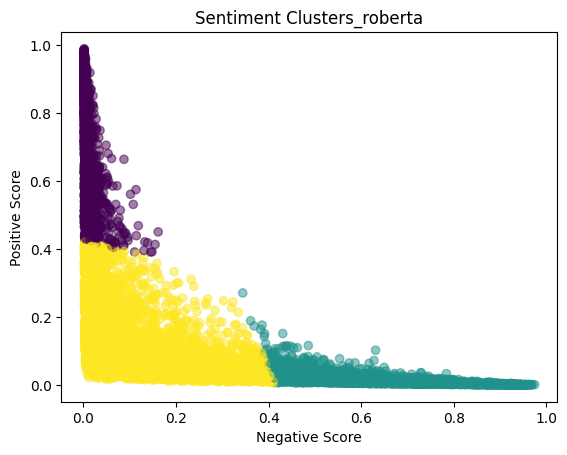

In [38]:
features = df[['roberta_negative_score', 'roberta_neutral_score', 'roberta_positive_score']].values
# Applying K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Visualization of clusters
plt.scatter(features[:, 0], features[:, 2], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Negative Score')
plt.ylabel('Positive Score')
plt.title('Sentiment Clusters_roberta')
plt.show()


##TOKENISATION BY DistilBERT

In [39]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [40]:
# Tokenizer and model
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Preprocessing for DistilBERT
class SentimentDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = df['abstract'].apply(preprocess_text).tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
        }

# Preparing data
dataset = SentimentDataset(df, tokenizer)

# DataLoader
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Predicting sentiment
model.eval()
positive_scores, neutral_scores, negative_scores = [], [], []

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=-1).cpu().numpy()

        for prob in probabilities:
            negative_scores.append(prob[0])
            neutral_scores.append(prob[1])
            positive_scores.append(prob[2])

# Adding predictions to the DataFrame
df['distilbert_positive_score'] = positive_scores
df['distilbert_neutral_score'] = neutral_scores
df['distilbert_negative_score'] = negative_scores
df['distilbert_compound_score'] = (df['distilbert_positive_score'] - df['distilbert_negative_score']) * (1 - df['distilbert_neutral_score'])
df['distilbert_sentiment'] =df['distilbert_compound_score'].apply(assign_sentiment_label)

# Save the results
output_file = "sentiment_results.csv"
df.to_csv(output_file, index=False)
print(f"Sentiment predictions saved to {output_file}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sentiment predictions saved to sentiment_results.csv


In [41]:
df['distilbert_sentiment'].value_counts()

,count
distilbert_sentiment,
Neutral,9757


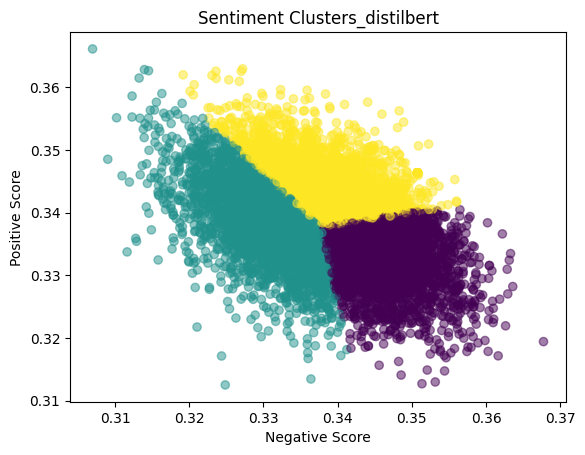

In [42]:
features = df[['distilbert_negative_score', 'distilbert_neutral_score', 'distilbert_positive_score']].values

# Applying K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Visualization of clusters
plt.scatter(features[:, 0], features[:, 2], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Negative Score')
plt.ylabel('Positive Score')
plt.title('Sentiment Clusters_distilbert')
plt.show()


## TOKENISATION BY ALBERT

In [43]:
from transformers import AlbertTokenizer, AlbertForSequenceClassification

In [44]:
import torch
import torch.nn.functional as F
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from google.colab import drive

# Loading ALBERT tokenizer and model
model_name = 'albert-base-v2'
tokenizer = AlbertTokenizer.from_pretrained(model_name)
model = AlbertForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Preprocessing for ALBERT
class SentimentDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = df['abstract'].apply(preprocess_text).tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
        }

# Preparing data
dataset = SentimentDataset(df, tokenizer)

# DataLoader
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prediction of sentiment
model.eval()
positive_scores, neutral_scores, negative_scores = [], [], []

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=-1).cpu().numpy()

        for prob in probabilities:
            negative_scores.append(prob[0])
            neutral_scores.append(prob[1])
            positive_scores.append(prob[2])

# Adding predictions to the DataFrame
df['albert_positive_score'] = positive_scores
df['albert_neutral_score'] = neutral_scores
df['albert_negative_score'] = negative_scores
df['albert_custom_compound_score'] = (df['albert_positive_score'] - df['albert_negative_score']) * (1 - df['albert_neutral_score'])
df['albert_sentiment'] =df['albert_custom_compound_score'].apply(assign_sentiment_label)

# # Save the results
# output_file = "albert_sentiment_results.csv"
# df.to_csv(output_file, index=False)
# print(f"Sentiment predictions saved to {output_file}")

# # Calculate custom compound score using the new formula
# df['albert_custom_compound_score'] = (df['albert_positive_score'] - df['albert_negative_score']) * (1 - df['albert_neutral_score'])

# Saving the DataFrame to a CSV file in Google Drive
output_file = "albert_sentiment_results_with_custom_compound.csv"
df[['abstract', 'headline', 'snippet', 'albert_positive_score',
    'albert_neutral_score', 'albert_negative_score',
    'albert_custom_compound_score']].to_csv(output_file, index=False)

print(f"Sentiment predictions with custom compound score saved to Google Drive at {output_file}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sentiment predictions with custom compound score saved to Google Drive at albert_sentiment_results_with_custom_compound.csv


In [45]:
df['albert_sentiment'].value_counts()

,count
albert_sentiment,
Neutral,9385
Positive,365
Negative,7


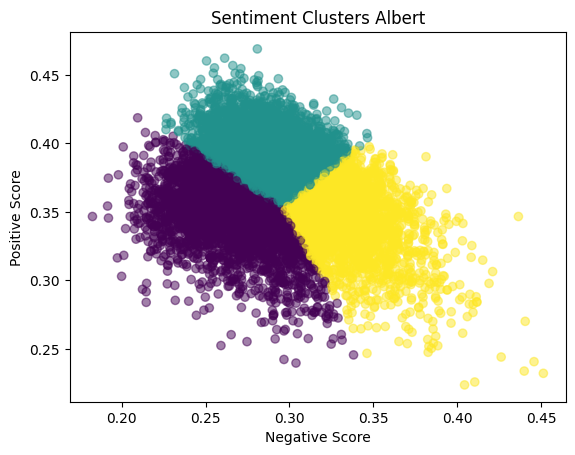

In [46]:
features = df[['albert_negative_score', 'albert_neutral_score', 'albert_positive_score']].values

# Applyinf K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Visualization of clusters
plt.scatter(features[:, 0], features[:, 2], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Negative Score')
plt.ylabel('Positive Score')
plt.title('Sentiment Clusters Albert')
plt.show()

In [47]:
# Loading specific columns from CSV files into DataFrames
model_1 = df[['vader_positive_score',
                'vader_negative_score', 'vader_neutral_score']].values
model_2 = df[['bert_positive_score',
                'bert_negative_score', 'bert_neutral_score']].values
model_3 = df[['roberta_positive_score',
                'roberta_negative_score', 'roberta_neutral_score']].values
model_4 = df[['distilbert_positive_score',
                'distilbert_negative_score', 'distilbert_neutral_score']].values
model_5 = df[['albert_positive_score',
                'albert_negative_score', 'albert_neutral_score']].values

# Combining models into a list
models = [model_1, model_2, model_3, model_4, model_5]

# Computing average sentiment vectors
averages = [model.mean(axis=0) for model in models]

# Computing pairwise cosine similarity
similarity_matrix = cosine_similarity(averages)

# Display of similarity matrix
print("Cosine Similarity Matrix:")
print(similarity_matrix)

Cosine Similarity Matrix:
[[1.         0.55037671 0.94114877 0.73520283 0.76069567]
 [0.55037671 1.         0.76454642 0.96728556 0.96040629]
 [0.94114877 0.76454642 1.         0.90295925 0.90453926]
 [0.73520283 0.96728556 0.90295925 1.         0.99519021]
 [0.76069567 0.96040629 0.90453926 0.99519021 1.        ]]


In [48]:
# Calculating cosine similarity for each record across models
record_similarities = []

for i in range(len(models)):
    for j in range(i + 1, len(models)):
        sim = cosine_similarity(models[i], models[j])
        record_similarities.append(np.mean(sim))

# Display of average similarity between pairs of models
print("Average Record-Level Similarities:", record_similarities)


Average Record-Level Similarities: [0.48268076725322434, 0.7492650643159772, 0.7203870153592806, 0.739549601777669, 0.5517475575408233, 0.8307141, 0.81981397, 0.7469635805378892, 0.7438483857145591, 0.9894717]


In [49]:
max_similarity = max(record_similarities)
min_similarity = min(record_similarities)
avg_similarity = sum(record_similarities) / len(record_similarities)

# Results
print(f"Length of records: {len(record_similarities)}")
print(f"Max Similarity: {max_similarity}")
print(f"Min Similarity: {min_similarity}")
print(f"Avg Similarity: {avg_similarity:.4f}")

Length of records: 10
Max Similarity: 0.9894716739654541
Min Similarity: 0.48268076725322434
Avg Similarity: 0.7374


## CONTENT BASED RECOMMENDATION SYSTEM


In [50]:
console = Console()

# Loading the dataset
file_path = 'updated_records_with_sentiment.csv'
df = pd.read_csv(file_path)

# Handling Missing Values
df.fillna('', inplace=True)

# Combining text columns for better feature representation
df['text_features'] = df['main_headline_clean'] + ' ' + df['abstract'] + ' ' + df['extracted_keywords']

# Adding scores
if not all(col in df.columns for col in ['positive_score', 'neutral_score', 'negative_score', 'compound_score']):
    analyzer = SentimentIntensityAnalyzer()
    df['sentiment_scores'] = df['abstract'].apply(lambda x: analyzer.polarity_scores(str(x)))
    df['positive_score'] = df['sentiment_scores'].apply(lambda x: x['pos'])
    df['neutral_score'] = df['sentiment_scores'].apply(lambda x: x['neu'])
    df['negative_score'] = df['sentiment_scores'].apply(lambda x: x['neg'])
    df['compound_score'] = df['sentiment_scores'].apply(lambda x: x['compound'])
    df.drop(columns=['sentiment_scores'], inplace=True)

# Text Vectorization using TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(df['text_features'])

# Normalization of Sentiment Scores
sentiment_features = df[['positive_score', 'neutral_score', 'negative_score', 'compound_score']]
scaler = MinMaxScaler()
scaled_sentiment = scaler.fit_transform(sentiment_features)

# Combining Text and Sentiment Features
combined_features = hstack([tfidf_matrix, scaled_sentiment])

# Computing Cosine Similarity
cosine_sim = cosine_similarity(combined_features, combined_features)

def display_recommendations_stylish(article_id, top_n=5):
    """
    Display recommendations in a styled format using Rich.

    Parameters:
        article_id (int): Index of the article in the dataset.
        top_n (int): Number of similar articles to recommend.
    """
    # Get similarity scores for the input article
    sim_scores = list(enumerate(cosine_sim[article_id]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    article_indices = [i[0] for i in sim_scores]

    # Fetch recommended articles
    recommendations = df.iloc[article_indices][['main_headline_clean', 'abstract', 'extracted_keywords', 'compound_score']].copy()
    recommendations['similarity_score'] = [sim[1] for sim in sim_scores]

    table = Table(title="Recommended Articles", box=box.DOUBLE)

    # Add columns
    table.add_column("Rank", style="cyan bold", justify="center")
    table.add_column("Headline", style="magenta bold", justify="left")
    table.add_column("Abstract", style="white", justify="left")
    table.add_column("Keywords", style="green", justify="left")
    table.add_column("Sentiment Score", style="yellow", justify="center")
    table.add_column("Similarity Score", style="blue", justify="center")

    # Add rows to the table
    for idx, row in recommendations.iterrows():
        table.add_row(
            str(idx + 1),
            row['main_headline_clean'][:50] + "..." if len(row['main_headline_clean']) > 50 else row['main_headline_clean'],
            row['abstract'][:80] + "..." if len(row['abstract']) > 80 else row['abstract'],
            row['extracted_keywords'],
            f"{row['compound_score']:.2f}",
            f"{row['similarity_score']:.2f}"
        )

    # Print the table
    console.print(table)

# Function for a dynamic recommedenation system that lets user interact
def choose_article_and_recommend(top_n=5):
    """
    Allow the user to select an article by index and display recommendations.
    """
    print("Available Articles:\n")
    for idx, main_headline_clean in enumerate(df['main_headline_clean']):
        print(f"[{idx}] {main_headline_clean[:50]}...")

    # Fetching user input
    article_id = int(input("\nEnter the index of the article for recommendations: "))
    display_recommendations_stylish(article_id=article_id, top_n=top_n)

# Function for searching for Article by Headline Text
def search_article_and_recommend(query, top_n=5):
    """
    Search for an article by partial headline text and display recommendations.
    """
    matches = df[df['main_headline_clean'].str.contains(query, case=False, na=False)]

    if matches.empty:
        print("No articles found with that keyword.")
        return

    print("\nMatching Articles:\n")
    for idx, row in matches.iterrows():
        print(f"[{idx}] {row['main_headline_clean'][:50]}...")

    article_id = int(input("\nEnter the index of the article for recommendations: "))
    display_recommendations_stylish(article_id=article_id, top_n=top_n)

# 1. Displaying recommendations for a specific article by index
display_recommendations_stylish(article_id=0, top_n=5)

# # 2. Allowing user to choose an article interactively
# choose_article_and_recommend(top_n=5)

# # 3. Search for an article by a keyword
# search_article_and_recommend(query="climate", top_n=5)


                                               Recommended Articles                                                
╔══════╦══════════════════════╦═══════════════════════╦══════════════════════╦═════════════════╦══════════════════╗
║ Rank ║ Headline             ║ Abstract              ║ Keywords             ║ Sentiment Score ║ Similarity Score ║
╠══════╬══════════════════════╬═══════════════════════╬══════════════════════╬═════════════════╬══════════════════╣
║  48  ║ Palin Lost a Shot at ║ Mary Peltola, a       ║ glocations:ALASKA;   ║      -0.05      ║       0.80       ║
║      ║ a House Seat but She ║ Democrat, defeated    ║ subject:Elections,   ║                 ║                  ║
║      ║ Has a Se...          ║ Sarah Palin, a        ║ House of             ║                 ║                  ║
║      ║                      ║ well-known            ║ Representatives;     ║                 ║                  ║
║      ║                      ║ Republican, in a      ║ persons:Palin,       ║                 ║                  ║
║      ║                      ║ sp...                 ║ Sarah;               ║                 ║                  ║
║      ║                      ║                       ║ persons:Peltola,     ║                 ║                  ║
║      ║                      ║                       ║ Mary;                ║                 ║                  ║
║      ║                      ║                       ║ persons:Begich, Nick ║                 ║                  ║
║      ║                      ║                       ║ III;                 ║                 ║                  ║
║      ║                      ║                       ║ organizations:Repub… ║                 ║                  ║
║      ║                      ║                       ║ Party;               ║                 ║                  ║
║      ║                      ║                       ║ organizations:Democ… ║                 ║                  ║
║      ║                      ║                       ║ Party;               ║                 ║                  ║
║      ║                      ║                       ║ subject:United       ║                 ║                  ║
║      ║                      ║                       ║ States Politics and  ║                 ║                  ║
║      ║                      ║                       ║ Government;          ║                 ║                  ║
║      ║                      ║                       ║ subject:Ranked-Choi… ║                 ║                  ║
║      ║                      ║                       ║ Voting               ║                 ║                  ║
║ 492  ║ A Day of Firsts for  ║ Representative Mary   ║ subject:United       ║      0.00       ║       0.75       ║
║      ║ Peltola in Congress  ║ Peltola was sworn in  ║ States Politics and  ║                 ║                  ║
║      ║ Starts a S...        ║ as the first Alaska   ║ Government;          ║                 ║                  ║
║      ║                      ║ Native and first      ║ subject:Alaska       ║                 ║                  ║
║      ║                      ║ wo...                 ║ Natives;             ║                 ║                  ║
║      ║                      ║                       ║ persons:Begich, Nick ║                 ║                  ║
║      ║                      ║                       ║ III; persons:Palin,  ║                 ║                  ║
║      ║                      ║                       ║ Sarah;               ║                 ║                  ║
║      ║                      ║                       ║ persons:Young, Don;  ║                 ║                  ║
║      ║                      ║                       ║ persons:Peltola,     ║                 ║                  ║
║      ║                      ║                       ║ Mary;                ║                 ║                  ║
║      ║                      ║                       ║ 

##HEAT MAP

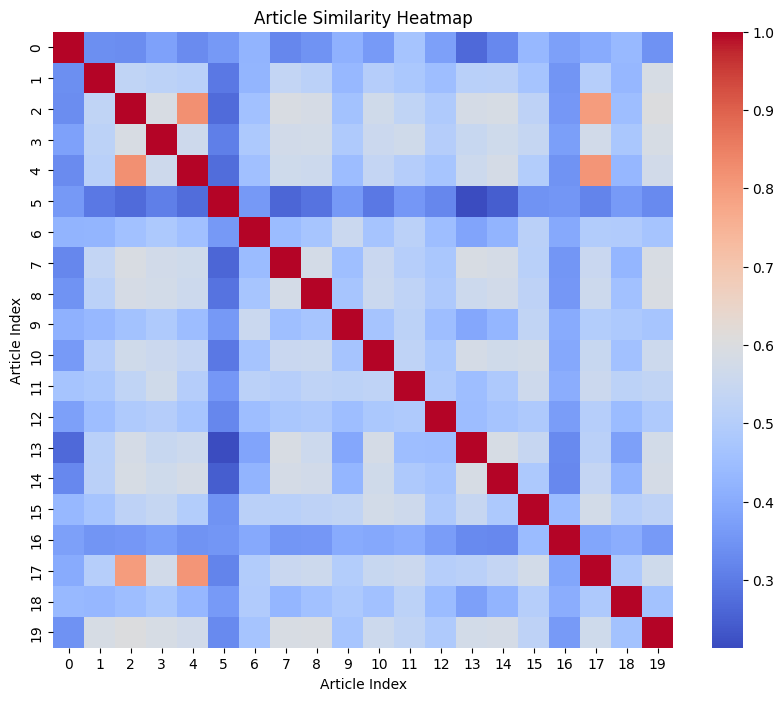

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Subset the similarity matrix for visualization
subset_sim = cosine_sim[:20, :20]

# Plotting heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(subset_sim, annot=False, cmap='coolwarm')
plt.title("Article Similarity Heatmap")
plt.xlabel("Article Index")
plt.ylabel("Article Index")
plt.show()


## SIMILARITY PROJECTION

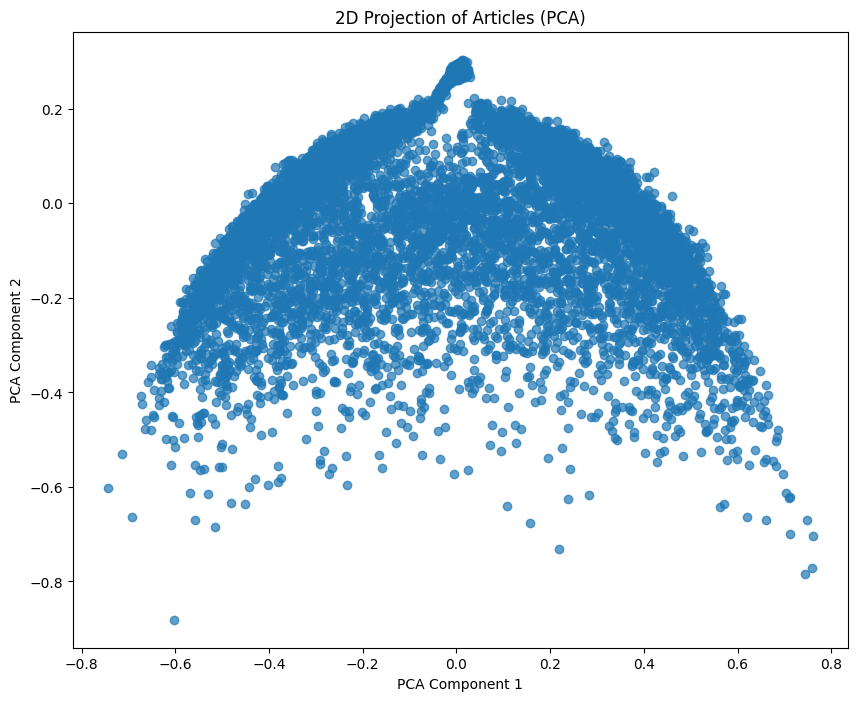

In [52]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducing dimensionality of combined features
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(combined_features.toarray())

# Plot of the articles in 2D
plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], alpha=0.7)
plt.title("2D Projection of Articles (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


## WORD CLOUD

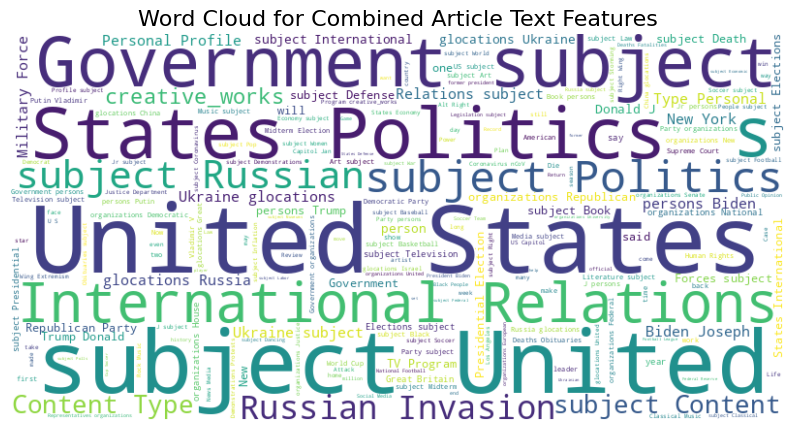

In [53]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combining all the text columns into a single string
text_data = " ".join(df['text_features'])

# Creating a word cloud object
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=None,
    colormap='viridis'
).generate(text_data)

# Display of the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Combined Article Text Features", fontsize=16)
plt.show()


## TOPIC MODELLING FOR RECOMMENDATIONS

In [54]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from gensim import corpora
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Load the dataset
# file_path = '/content/drive/My Drive/606/updated_records_with_sentiment.csv'
# df = pd.read_csv(file_path)

# Preprocessing  the text
df['text'] = df['main_headline_clean'] + ' ' + df['abstract'] + ' ' + df['extracted_keywords']
df.fillna('', inplace=True)

# Removing stopwords and tokenize the text
stop_words = stopwords.words('english')
df['processed_text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Creating a Document-Term Matrix (DTM) using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['processed_text'])

# Applying LDA for topic modeling
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(dtm)

# Fetchjing the topic distribution for each article
topic_distributions = lda.transform(dtm)

# Function to get article recommendations based on topic similarity
def get_topic_recommendations(article_idx, top_n=5):
    # Fetching the topic distribution of the selected article
    article_topic_dist = topic_distributions[article_idx]

    # Computing cosine similarity between the selected article and all other articles
    similarities = cosine_similarity([article_topic_dist], topic_distributions)

    # Fetching the most similar articles
    similar_articles = similarities[0].argsort()[-top_n-1:-1][::-1]

    # Return recommended article headlines
    recommended_headlines = df.iloc[similar_articles]['main_headline_clean']
    return recommended_headlines

recommended_articles = get_topic_recommendations(0, top_n=5)
print("Recommended Articles for the First Article:")
print(recommended_articles)

# Visualization of the topics by showing the top words in each topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"\nTopic #{topic_idx + 1}:")
    top_words_idx = topic.argsort()[-10:][::-1]
    top_words = [vectorizer.get_feature_names_out()[i] for i in top_words_idx]
    print(" ".join(top_words))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Recommended Articles for the First Article:
583     The Political Calculations Behind DeSantiss Mi...
7793    GOP Immigration Agenda Faces Stiff Odds in Div...
7887    Tennessee GOP Cuts Session Short With No Actio...
8612    Asylum Debate Snarls Efforts to Forge an Immig...
8556    House Approves Stringent GOP Border Bill Attac...
Name: main_headline_clean, dtype: object

Topic #1:
persons organizations football league basketball national baseball tennis new team

Topic #2:
glocations ukraine persons international russian russia relations military organizations defense

Topic #3:
glocations persons rights human turkey india deaths mexico protests people

Topic #4:
organizations crimes sudan persons war humanity wagner genocide published children

Topic #5:
creative_works persons book tv books program literature television content type

Topic #6:
persons organizations trump donald right news election politics government court

Topic #7:
organizations persons glocations soccer britain g

## WORD CLOUD

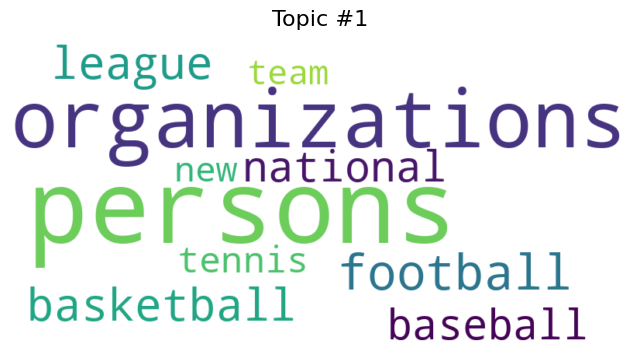

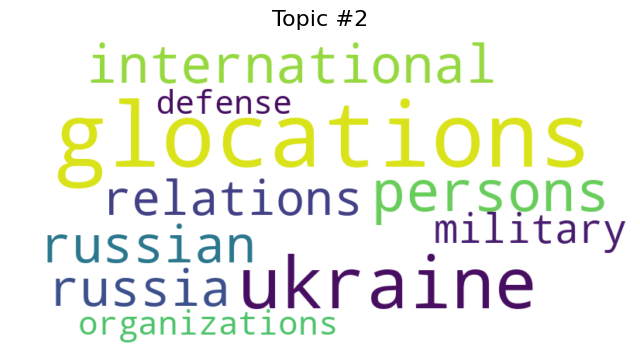

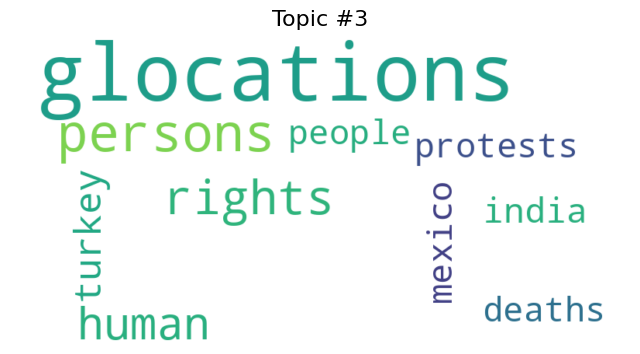

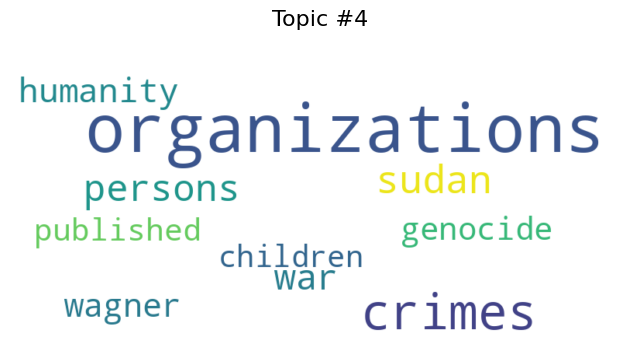

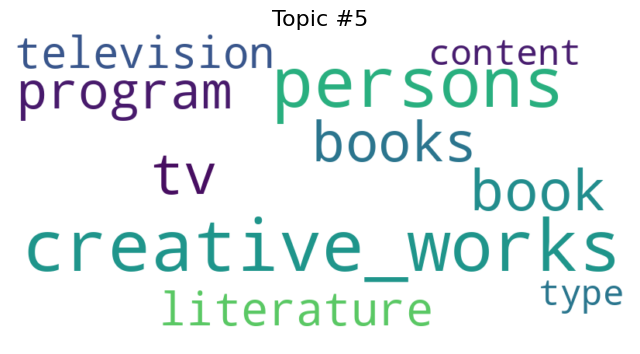

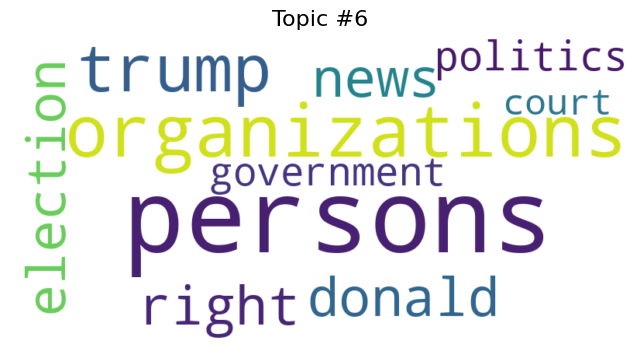

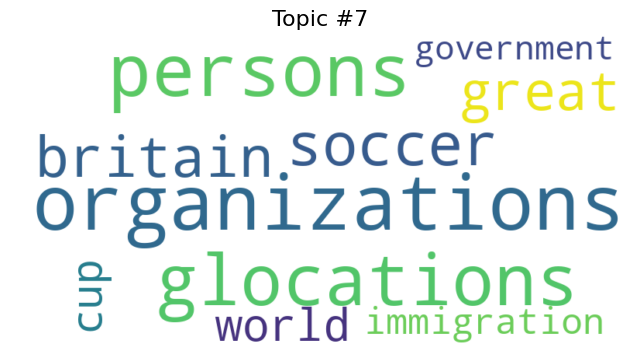

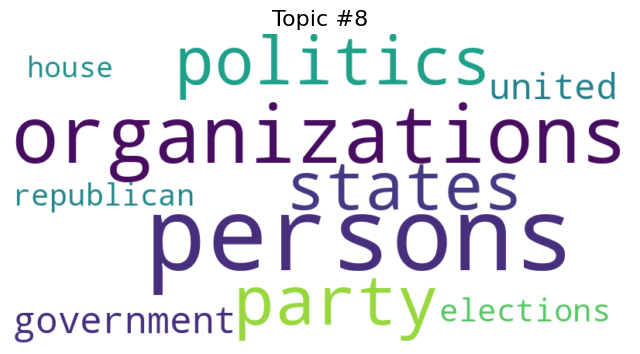

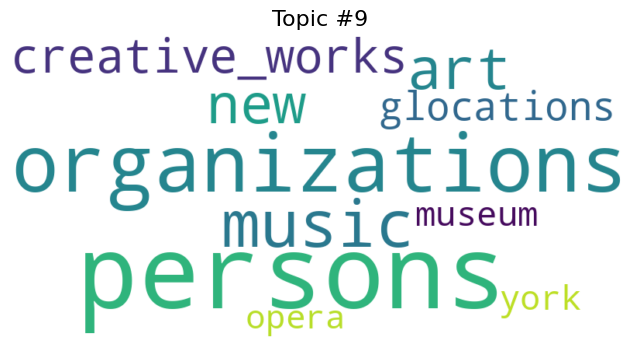

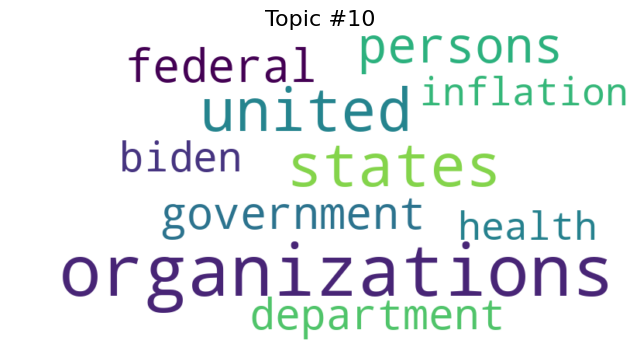

In [55]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_clouds():
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[-10:][::-1]
        top_words = [vectorizer.get_feature_names_out()[i] for i in top_words_idx]

        word_freq = {word: topic[i] for i, word in zip(top_words_idx, top_words)}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

        plt.figure(figsize=(8, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Topic #{topic_idx + 1}", fontsize=16)
        plt.axis('off')
        plt.show()

plot_word_clouds()
